## Prism Data

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
consdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-consDF.pqt') #shows delinquents and credit score
acctdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt') #displays accounts and balances
trxndf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt') #each transaction with category number and amounts
cat_map = pd.read_csv('/uss/hdsi-prismdata/q2-ucsd-cat-map.csv') #mapping for category numbers

In [3]:
cat_map

,category_id,category
0,0,SELF_TRANSFER
1,1,EXTERNAL_TRANSFER
2,2,DEPOSIT
3,3,PAYCHECK
4,4,MISCELLANEOUS
5,5,PAYCHECK_PLACEHOLDER
6,6,REFUND
7,7,INVESTMENT_INCOME
8,8,OTHER_BENEFITS
9,9,UNEMPLOYMENT_BENEFITS


In [4]:
consdf.dropna()['prism_consumer_id'].nunique(),acctdf['prism_consumer_id'].nunique(),trxndf['prism_consumer_id'].nunique()

(12000, 13009, 14492)

In [5]:
total = set(consdf.dropna()['prism_consumer_id'].unique()) & set(acctdf['prism_consumer_id'].unique()) & set(trxndf['prism_consumer_id'].unique())
len(total)

10122

### Week 3

In [6]:
initial_df = (
    acctdf
    .merge(consdf, on='prism_consumer_id', how='inner')
    .groupby(['prism_consumer_id'])
    .agg(
        balance=('balance', 'sum'),
        balance_date=('balance_date', 'max')
    )
    .reset_index()
).merge(trxndf,on='prism_consumer_id')
initial_df

,prism_consumer_id,balance,balance_date,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,0,320.37,2021-08-31,136696,4,0.09,CREDIT,2021-03-19
1,0,320.37,2021-08-31,136697,4,0.05,CREDIT,2021-04-16
2,0,320.37,2021-08-31,136698,4,0.06,CREDIT,2021-05-21
3,0,320.37,2021-08-31,136699,4,0.04,CREDIT,2021-06-18
4,0,320.37,2021-08-31,136700,4,0.02,CREDIT,2021-07-16
...,...,...,...,...,...,...,...,...
5202934,9999,-9.02,2023-08-09,1522635,16,66.63,DEBIT,2023-08-08
5202935,9999,-9.02,2023-08-09,1522636,14,16.91,DEBIT,2023-08-08
5202936,9999,-9.02,2023-08-09,1522637,14,3.52,DEBIT,2023-08-08
5202937,9999,-9.02,2023-08-09,1522638,16,7.99,DEBIT,2023-08-08


In [7]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
initial_df["category"] = initial_df["category"].replace(mapping)
monthly_summary=initial_df.copy()
monthly_summary['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
monthly_summary['posted_date'] = pd.to_datetime(monthly_summary['posted_date'])
monthly_summary = (
    monthly_summary
    .groupby(['prism_consumer_id', monthly_summary['posted_date'].dt.to_period('M')])
    .agg(
        starting_balance=('balance', 'first'),
        monthly_total=('balance', 'sum'),
        trxndf_count = ('balance', 'count')
    )
    .reset_index()
)
monthly_summary['posted_date'] = monthly_summary['posted_date'].dt.to_timestamp()

In [8]:
monthly_summary = monthly_summary.merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()

In [9]:
# ensure date type
monthly_summary["posted_date"] = pd.to_datetime(monthly_summary["posted_date"])

# sort properly
monthly_summary = monthly_summary.sort_values(["prism_consumer_id", "posted_date"])

# calculate running balance
monthly_summary["monthly_balance"] = (
    monthly_summary["starting_balance"]
    + monthly_summary.groupby("prism_consumer_id")["monthly_total"].cumsum()
)
monthly_summary

,prism_consumer_id,posted_date,starting_balance,monthly_total,trxndf_count,DQ_TARGET,monthly_balance
0,0,2021-03-01,320.37,10572.21,33,0.0,10892.58
1,0,2021-04-01,320.37,22105.53,69,0.0,32998.11
2,0,2021-05-01,320.37,11853.69,37,0.0,44851.80
3,0,2021-06-01,320.37,27231.45,85,0.0,72083.25
4,0,2021-07-01,320.37,23707.38,74,0.0,95790.63
...,...,...,...,...,...,...,...
74439,999,2020-11-01,2236.37,140891.31,63,0.0,237055.22
74440,999,2020-12-01,2236.37,351110.09,157,0.0,588165.31
74441,999,2021-01-01,2236.37,272837.14,122,0.0,861002.45
74442,999,2021-02-01,2236.37,339928.24,152,0.0,1200930.69


In [10]:
del_df = monthly_summary[monthly_summary['DQ_TARGET'] == 1]
nondel_df = monthly_summary[monthly_summary['DQ_TARGET'] == 0]
ids_1 = del_df["prism_consumer_id"].dropna().unique()
ids_0 = del_df["prism_consumer_id"].dropna().unique()

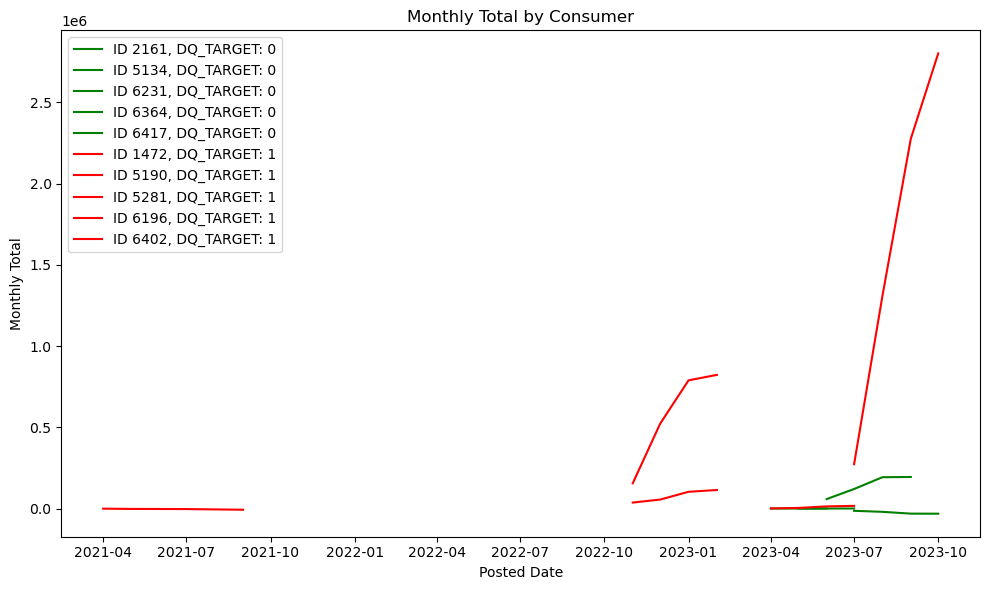

In [11]:
random.seed(10)

n=5

ids = np.random.choice(ids_0, size=n, replace=False)
ids2 = np.random.choice(ids_1,size=n,replace=False)

subset = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids)]
subset2 = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids2)]

plt.figure(figsize=(10, 6))

for pid, df in subset.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 0',color='green')
    
for pid, df in subset2.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 1',color='red')

plt.xlabel('Posted Date')
plt.ylabel('Monthly Total')
plt.title('Monthly Total by Consumer')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
monthly_summary

,prism_consumer_id,posted_date,starting_balance,monthly_total,trxndf_count,DQ_TARGET,monthly_balance
0,0,2021-03-01,320.37,10572.21,33,0.0,10892.58
1,0,2021-04-01,320.37,22105.53,69,0.0,32998.11
2,0,2021-05-01,320.37,11853.69,37,0.0,44851.80
3,0,2021-06-01,320.37,27231.45,85,0.0,72083.25
4,0,2021-07-01,320.37,23707.38,74,0.0,95790.63
...,...,...,...,...,...,...,...
74439,999,2020-11-01,2236.37,140891.31,63,0.0,237055.22
74440,999,2020-12-01,2236.37,351110.09,157,0.0,588165.31
74441,999,2021-01-01,2236.37,272837.14,122,0.0,861002.45
74442,999,2021-02-01,2236.37,339928.24,152,0.0,1200930.69


### mtotal_df

In [13]:
mtotal_df = monthly_summary.groupby('prism_consumer_id').agg(
        DQ_TARGET = ('DQ_TARGET', 'first'),
        monthly_mean=('monthly_total', 'mean'),
        monthly_max=('monthly_total', 'max'),
        monthly_min=('monthly_total', 'min'),
        trxndf_count = ('trxndf_count','first'),
        month_count=('monthly_total', 'count')
    )
mtotal_df

,DQ_TARGET,monthly_mean,monthly_max,monthly_min,trxndf_count,month_count
prism_consumer_id,,,,,,
0,0.0,1.867299e+04,27231.45,8970.36,33,7
1,0.0,1.481371e+05,208052.46,102375.02,31,7
10,0.0,4.015226e+04,60169.52,19781.76,31,7
100,0.0,5.399456e+04,63731.28,45142.99,19,6
1000,0.0,2.871107e+03,3524.25,476.25,5,7
...,...,...,...,...,...,...
995,0.0,2.053630e+06,3162590.31,670852.49,17,7
996,0.0,0.000000e+00,0.00,0.00,32,7
997,0.0,4.787867e+06,6756531.35,1404823.35,21,7


In [14]:
from sklearn.model_selection import train_test_split

X = mtotal_df.drop(columns='DQ_TARGET')
y = mtotal_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [15]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6773498120150389
              precision    recall  f1-score   support

         0.0       0.97      0.61      0.75      2315
         1.0       0.16      0.77      0.26       216

    accuracy                           0.63      2531
   macro avg       0.56      0.69      0.50      2531
weighted avg       0.90      0.63      0.71      2531



In [16]:
cd_df = initial_df[['prism_consumer_id','amount','credit_or_debit']].groupby(['prism_consumer_id','credit_or_debit']).sum().reset_index()
cd_df

,prism_consumer_id,credit_or_debit,amount
0,0,CREDIT,14386.82
1,0,DEBIT,14908.41
2,1,CREDIT,24903.80
3,1,DEBIT,23098.37
4,10,CREDIT,20576.56
...,...,...,...
25008,9997,DEBIT,16702.92
25009,9998,CREDIT,14566.37
25010,9998,DEBIT,15399.47
25011,9999,CREDIT,31777.82


### cd_df

In [17]:
cd_df = (
    cd_df
    .pivot_table(
        index='prism_consumer_id',
        columns='credit_or_debit',
        values='amount',
        aggfunc='sum',
        fill_value=0
    )
    .assign(
        credit_debit_ratio=lambda x: x['CREDIT'] / (x['DEBIT'] + 1),
        net_flow=lambda x: x['CREDIT'] - x['DEBIT']
    )
)

In [18]:
cd_df = cd_df.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
cd_df

,prism_consumer_id,CREDIT,DEBIT,credit_debit_ratio,net_flow,DQ_TARGET
0,0,14386.82,14908.41,0.964949,-521.59,0.0
1,1,24903.80,23098.37,1.078116,1805.43,0.0
2,10,20576.56,21766.60,0.945284,-1190.04,0.0
3,100,35236.84,39742.61,0.886604,-4505.77,0.0
4,1000,78353.07,77914.99,1.005610,438.08,0.0
...,...,...,...,...,...,...
12598,995,53309.15,31466.47,1.694103,21842.68,0.0
12607,996,222962.79,196249.61,1.136113,26713.18,0.0
12616,997,66176.94,81076.60,0.816217,-14899.66,0.0
12626,998,71714.74,66207.01,1.083173,5507.73,0.0


In [19]:
from sklearn.model_selection import train_test_split

X = cd_df.drop(columns = ['prism_consumer_id','DQ_TARGET'])
y = cd_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [20]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6278297736181105
              precision    recall  f1-score   support

         0.0       0.95      0.38      0.54      2315
         1.0       0.11      0.80      0.19       216

    accuracy                           0.41      2531
   macro avg       0.53      0.59      0.36      2531
weighted avg       0.88      0.41      0.51      2531



In [21]:
net_df = initial_df[['prism_consumer_id','posted_date','category','credit_or_debit','amount']].copy()
net_df['amount'] = np.where(net_df['credit_or_debit'] == 'DEBIT', -net_df['amount'],net_df['amount'])
net_df['posted_date'] = pd.to_datetime(net_df['posted_date'])
net_df['month'] = net_df['posted_date'].dt.to_period('M')
mn_df = net_df.groupby(['prism_consumer_id','month']).agg(
        monthly_total=('amount', 'sum'),
        monthly_std =('amount','std')
    ).reset_index()
mn_df

,prism_consumer_id,month,monthly_total,monthly_std
0,0,2021-03,401.34,332.210452
1,0,2021-04,830.73,238.858943
2,0,2021-05,201.50,163.856341
3,0,2021-06,-2584.24,102.201363
4,0,2021-07,-71.38,187.201528
...,...,...,...,...
74473,9998,2023-10,15.86,252.389925
74474,9999,2023-05,3175.69,480.769524
74475,9999,2023-06,-236.42,428.377690
74476,9999,2023-07,-1288.34,428.713815


### monthly_features

In [22]:
monthly_features = mn_df.groupby(['prism_consumer_id']).agg(
    monthly_net_total=('monthly_total', 'sum'),
    monthly_net_avg=('monthly_total', 'mean'),
    monthly_net_max=('monthly_total', 'max'),
    monthly_net_min=('monthly_total', 'min'),
    monthly_std_avg=('monthly_std', 'mean')
).reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
monthly_features['prism_consumer_id'] = monthly_features['prism_consumer_id'].astype(int)
mtotal_df = mtotal_df.reset_index()
mtotal_df['prism_consumer_id'] = mtotal_df['prism_consumer_id'].astype(int)
cd_df['prism_consumer_id'] = cd_df['prism_consumer_id'].astype(int)
monthly_features['net_range'] = monthly_features['monthly_net_max'] - monthly_features['monthly_net_min']
monthly_features

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,DQ_TARGET,net_range
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,0.0,3414.97
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,0.0,2049.75
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,0.0,1402.85
3,100,-4505.77,-750.961667,1276.72,-3332.81,832.186871,0.0,4609.53
4,1000,438.08,62.582857,2982.67,-2884.56,1223.790895,0.0,5867.23
...,...,...,...,...,...,...,...,...
12598,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,0.0,13456.94
12607,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,0.0,58275.91
12616,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,0.0,3948.44
12626,998,5507.73,786.818571,3359.83,-1022.35,537.836676,0.0,4382.18


In [23]:
from sklearn.model_selection import train_test_split

X = monthly_features.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = monthly_features['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [24]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6050277339575594
              precision    recall  f1-score   support

         0.0       0.96      0.36      0.53      2285
         1.0       0.11      0.82      0.19       215

    accuracy                           0.40      2500
   macro avg       0.53      0.59      0.36      2500
weighted avg       0.88      0.40      0.50      2500



In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.6840506844435398


In [26]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [27]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [28]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.6895353926008855
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2285
         1.0       0.56      0.02      0.04       215

    accuracy                           0.91      2500
   macro avg       0.74      0.51      0.50      2500
weighted avg       0.88      0.91      0.88      2500



In [29]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10)

monthly_net_total    0.191621
monthly_net_max      0.188124
net_range            0.170834
monthly_std_avg      0.152746
monthly_net_avg      0.149985
monthly_net_min      0.146690
dtype: float32

### catsum_df

In [30]:

initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'])['amount'].sum().reset_index()

In [31]:
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount'
    )
    .fillna(0)
)
cat_pivot

category,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,AUTO_LOAN,BANKING_CATCH_ALL,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,CORPORATE_PAYMENTS,CREDIT_CARD_PAYMENT,...,REFUND,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,0.00,-540.00,-527.15,0.00,-1980.00,0.00,0.00,0.0,0.0,0.00,...,19.96,0.0,0.0,0.0,1.741030e+03,2603.52,0.0,-2.48,-108.75,0.0
1,0.00,-6999.13,-195.18,0.00,0.00,0.00,-251.43,0.0,0.0,0.00,...,2.42,0.0,0.0,0.0,0.000000e+00,2325.40,0.0,-51.80,0.00,0.0
10,0.00,-4112.00,-483.06,0.00,0.00,0.00,0.00,0.0,0.0,-180.00,...,92.33,-103.0,0.0,0.0,-5.684342e-14,0.00,0.0,-35.04,0.00,0.0
100,0.00,-200.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,-16188.17,...,11.75,0.0,0.0,0.0,-4.202680e+03,0.00,0.0,0.00,0.00,0.0
1000,0.00,0.00,-204.03,0.00,0.00,0.00,0.00,0.0,0.0,-14756.05,...,1.37,0.0,0.0,0.0,-3.162727e+04,0.00,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,-1260.18,-115.56,-672.78,0.00,-53.98,-167.60,0.0,0.0,-512.48,...,0.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,0.00,0.0
9996,0.00,0.00,-75.39,0.00,-184.34,0.00,0.00,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,-27.69,0.0
9997,-10.50,-1053.25,-217.60,-962.16,0.00,-230.00,-729.08,0.0,0.0,-829.00,...,335.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,-136.34,0.0


In [32]:
outflows = cat_pivot.clip(upper=0).abs()
inflows  = cat_pivot.clip(lower=0)

cat_features = pd.DataFrame(index=cat_pivot.index)

cat_features['total_outflows'] = outflows.sum(axis=1)
cat_features['total_inflows']  = inflows.sum(axis=1)
cat_features['net_flow']       = cat_pivot.sum(axis=1)


In [33]:
for col in outflows.columns:
    cat_features[f'{col}_outflow_ratio'] = (
        outflows[col] / (cat_features['total_outflows'] + 1)
    )


In [34]:
# Income reliance
cat_features['paycheck_ratio'] = (
    inflows.get('PAYCHECK', 0) / (cat_features['total_inflows'] + 1)
)

# Cash usage
cat_features['atm_cash_ratio'] = (
    outflows.get('ATM_CASH', 0) / (cat_features['total_outflows'] + 1)
)

# Entertainment vs essentials proxy
cat_features['entertainment_ratio'] = (
    outflows.get('ENTERTAINMENT', 0) / (cat_features['total_outflows'] + 1)
)

# Refund dependence
cat_features['refund_ratio'] = (
    inflows.get('REFUND', 0) / (cat_features['total_inflows'] + 1)
)

In [35]:
outflows = outflows.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
outflows

,prism_consumer_id,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,AUTO_LOAN,BANKING_CATCH_ALL,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,CORPORATE_PAYMENTS,...,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS,DQ_TARGET
0,0,0.0,540.00,527.15,0.0,1980.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.000000e+00,0.0,0.0,2.48,108.75,0.0,0.0
1,1,0.0,6999.13,195.18,0.0,0.00,0.00,251.43,0.0,0.0,...,0.00,0.0,0.0,0.000000e+00,0.0,0.0,51.80,0.00,0.0,0.0
2,10,0.0,4112.00,483.06,0.0,0.00,0.00,0.00,0.0,0.0,...,103.00,0.0,0.0,5.684342e-14,0.0,0.0,35.04,0.00,0.0,0.0
3,100,0.0,200.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,4.202680e+03,0.0,0.0,0.00,0.00,0.0,0.0
4,1000,0.0,0.00,204.03,0.0,0.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,3.162727e+04,0.0,0.0,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12598,995,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,...,5670.79,0.0,0.0,0.000000e+00,0.0,0.0,0.00,0.00,0.0,0.0
12607,996,0.0,11500.00,1090.58,0.0,67.79,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.000000e+00,0.0,0.0,12.00,5433.00,0.0,0.0
12616,997,0.0,11640.00,0.00,0.0,300.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,4.048990e+03,0.0,0.0,0.00,0.00,0.0,0.0
12626,998,0.0,1130.57,1958.32,0.0,3441.84,881.68,568.81,209.4,0.0,...,693.95,0.0,0.0,0.000000e+00,0.0,0.0,63.50,496.28,0.0,0.0


In [36]:
cat_features = cat_features.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()

In [37]:
from sklearn.model_selection import train_test_split

X = outflows.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = outflows['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [38]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6716342692584594
              precision    recall  f1-score   support

         0.0       0.95      0.53      0.68      2315
         1.0       0.13      0.73      0.21       216

    accuracy                           0.54      2531
   macro avg       0.54      0.63      0.45      2531
weighted avg       0.88      0.54      0.64      2531



In [39]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.7397808175345972


In [40]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [41]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.7454403647708183
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2315
         1.0       0.56      0.04      0.08       216

    accuracy                           0.92      2531
   macro avg       0.74      0.52      0.52      2531
weighted avg       0.89      0.92      0.88      2531



In [42]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(5)

OVERDRAFT              0.040062
ACCOUNT_FEES           0.038719
CREDIT_CARD_PAYMENT    0.031763
RTO_LTO                0.031227
INSURANCE              0.031061
dtype: float32

In [43]:
categories_with_weight = importance[importance > 0].index.tolist()
categories_with_weight = categories_with_weight + ['prism_consumer_id']

In [44]:
add_df = cat_features[['prism_consumer_id','refund_ratio','paycheck_ratio']].copy()
add_df['prism_consumer_id'] = add_df['prism_consumer_id'].astype(int)
outflows['prism_consumer_id'] = outflows['prism_consumer_id'].astype(int)
out_df = outflows[categories_with_weight].copy()
out_df

,OVERDRAFT,ACCOUNT_FEES,CREDIT_CARD_PAYMENT,RTO_LTO,INSURANCE,AUTOMOTIVE,BNPL,INVESTMENT,GROCERIES,ENTERTAINMENT,...,RENT,GOVERNMENT_SERVICES,TAX,TRANSPORATION,FITNESS,BANKING_CATCH_ALL,LEGAL,GIFTS_DONATIONS,RISK_CATCH_ALL,prism_consumer_id
0,0.0,0.0,0.00,0.0,0.00,527.15,0.00,0.0,997.63,151.71,...,0.00,0.0,0.0,2.48,150.60,1980.00,0.0,0.0,0.0,0
1,0.0,0.0,0.00,0.0,0.00,195.18,251.43,0.0,427.27,275.25,...,0.00,0.0,0.0,51.80,0.00,0.00,0.0,0.0,0.0,1
2,0.0,0.0,180.00,0.0,0.00,483.06,0.00,0.0,621.79,107.64,...,103.00,0.0,0.0,35.04,0.00,0.00,0.0,50.0,0.0,10
3,0.0,0.0,16188.17,0.0,1942.76,0.00,0.00,0.0,403.50,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,100
4,0.0,0.0,14756.05,0.0,0.00,204.03,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12598,0.0,0.0,14832.19,0.0,355.27,0.00,0.00,0.0,472.66,0.00,...,5670.79,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,995
12607,0.0,0.0,17665.91,0.0,0.00,1090.58,0.00,3000.0,1074.43,1330.34,...,0.00,1807.4,0.0,12.00,0.00,67.79,0.0,0.0,0.0,996
12616,0.0,0.0,6121.09,0.0,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,300.00,0.0,0.0,0.0,997
12626,0.0,0.0,300.00,0.0,1047.42,1958.32,568.81,0.0,4907.57,625.97,...,693.95,40.0,0.0,63.50,75.49,3441.84,0.0,0.0,0.0,998


### catavg_df

In [45]:
initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'])['amount'].mean().reset_index()
cat_df

,prism_consumer_id,category,amount
0,0,ATM_CASH,180.000000
1,0,AUTOMOTIVE,25.102381
2,0,BANKING_CATCH_ALL,396.000000
3,0,DEPOSIT,500.000000
4,0,ENTERTAINMENT,25.285000
...,...,...,...
239827,9999,MISCELLANEOUS,77.280526
239828,9999,PAYCHECK,2563.146667
239829,9999,REFUND,23.760000
239830,9999,TRANSPORATION,9.480714


In [46]:
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount'
    )
    .fillna(0)
)
cat_pivot.columns = cat_pivot.columns + "_trxnavg"
cat_pivot = cat_pivot.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
cat_pivot['prism_consumer_id'] = cat_pivot['prism_consumer_id'].astype(int)
cat_pivot

,prism_consumer_id,ACCOUNT_FEES_trxnavg,ATM_CASH_trxnavg,AUTOMOTIVE_trxnavg,AUTO_LOAN_trxnavg,BANKING_CATCH_ALL_trxnavg,BILLS_UTILITIES_trxnavg,BNPL_trxnavg,CHILD_DEPENDENTS_trxnavg,CORPORATE_PAYMENTS_trxnavg,...,RENT_trxnavg,RISK_CATCH_ALL_trxnavg,RTO_LTO_trxnavg,SELF_TRANSFER_trxnavg,TAX_trxnavg,TIME_OR_STUFF_trxnavg,TRANSPORATION_trxnavg,TRAVEL_trxnavg,UNEMPLOYMENT_BENEFITS_trxnavg,DQ_TARGET
0,0,0.0,180.000000,25.102381,0.0,396.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,116.685652,867.840,0.000000,2.480000,54.375000,0.0,0.0
1,1,0.0,199.975143,27.882857,0.0,0.00,0.000000,17.959286,0.0,0.0,...,0.000000,0.0,0.0,233.410256,1162.700,0.000000,25.900000,0.000000,0.0,0.0
2,10,0.0,228.444444,21.002609,0.0,0.00,0.000000,0.000000,0.0,0.0,...,103.000000,0.0,0.0,237.568750,0.000,0.000000,17.520000,0.000000,0.0,0.0
3,100,0.0,200.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,547.296667,0.000,0.000000,0.000000,0.000000,0.0,0.0
4,1000,0.0,0.000000,34.005000,0.0,0.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,828.920370,0.000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12598,995,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,...,1134.158000,0.0,0.0,1250.937000,626.432,0.000000,0.000000,0.000000,0.0,0.0
12607,996,0.0,1437.500000,35.180000,0.0,67.79,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,3532.145542,0.000,0.000000,12.000000,493.909091,0.0,0.0
12616,997,0.0,223.846154,0.000000,0.0,300.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,940.464154,2516.000,20.149683,0.000000,0.000000,0.0,0.0
12626,998,0.0,94.214167,41.666383,0.0,573.64,146.946667,43.754615,34.9,0.0,...,231.316667,0.0,0.0,759.527885,2991.340,0.000000,12.700000,248.140000,0.0,0.0


In [47]:
from sklearn.model_selection import train_test_split

X = cat_pivot.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = cat_pivot['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [48]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.683237341012719
              precision    recall  f1-score   support

         0.0       0.96      0.56      0.71      2315
         1.0       0.13      0.72      0.22       216

    accuracy                           0.57      2531
   macro avg       0.54      0.64      0.46      2531
weighted avg       0.88      0.57      0.66      2531



In [49]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.748894088472922


In [50]:
# from sklearn.metrics import roc_auc_score, classification_report

# y_pred = xgb.predict(X_test)
# y_prob = xgb.predict_proba(X_test)[:, 1]

# print("ROC AUC:", roc_auc_score(y_test, y_prob))
# print(classification_report(y_test, y_pred))

### Income_Df

In [51]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
trxndf["category"] = trxndf["category"].replace(mapping)

income_categories = [
    'PAYCHECK',
    'DEPOSIT',
    'UNEMPLOYMENT_BENEFITS',
    'OTHER_BENEFITS',
    'PENSION',
    'INVESTMENT_INCOME'
]

income_df = trxndf[
    trxndf['category'].isin(income_categories)
].copy()
income_df['prism_transaction_id'].duplicated().sum()
income_df['posted_date'] = pd.to_datetime(income_df['posted_date'])

In [52]:
trxndf

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,MISCELLANEOUS,0.05,CREDIT,2021-04-16
1,3023,1,LOAN,481.56,CREDIT,2021-04-30
2,3023,2,MISCELLANEOUS,0.05,CREDIT,2021-05-16
3,3023,3,MISCELLANEOUS,0.07,CREDIT,2021-06-16
4,3023,4,MISCELLANEOUS,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,BILLS_UTILITIES,4.96,DEBIT,2022-03-11
6407317,10533,6405305,LOAN,63.48,DEBIT,2022-03-30
6407318,10533,6405306,LOAN,53.99,DEBIT,2022-03-30
6407319,10533,6405307,LOAN,175.98,DEBIT,2022-03-31


In [53]:
income_time = (
    income_df
    .groupby('prism_consumer_id')
    .agg(
        first_income_date=('posted_date', 'min'),
        last_income_date=('posted_date', 'max')
    )
    .reset_index()
)

income_time['income_span_days'] = (
    income_time['last_income_date'] - income_time['first_income_date']
).dt.days

In [54]:
income_df = income_time[['prism_consumer_id','income_span_days']]
income_df['prism_consumer_id'] = income_time['prism_consumer_id'].astype(int)
income_df

/tmp/ipykernel_38699/1942401210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_df['prism_consumer_id'] = income_time['prism_consumer_id'].astype(int)


,prism_consumer_id,income_span_days
0,0,176
1,1,168
2,10,168
3,100,169
4,1000,177
...,...,...
13873,9995,77
13874,9996,61
13875,9997,84
13876,9998,71


### Try the counts of negative categories, look at external transfer as well

remove credit cards, loans, lines of credit

In [55]:
acctdf

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


## Main model testing

In [56]:
cat_pivot= cat_pivot.drop(columns='DQ_TARGET')

In [57]:
main_df= monthly_features.merge(mtotal_df,on='prism_consumer_id')
main_df['DQ_TARGET'] = main_df['DQ_TARGET_x']
main_df = main_df.drop(columns=['DQ_TARGET_x','DQ_TARGET_y'])
cd_df = cd_df.drop(columns=['net_flow','DQ_TARGET'])
main_df= main_df.merge(cd_df,on='prism_consumer_id')
main_df= main_df.merge(add_df,on='prism_consumer_id')
main_df= main_df.merge(out_df,on='prism_consumer_id')
main_df= main_df.merge(income_df,on='prism_consumer_id')
main_df= main_df.merge(cat_pivot,on='prism_consumer_id')
main_df

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,REFUND_trxnavg,RENT_trxnavg,RISK_CATCH_ALL_trxnavg,RTO_LTO_trxnavg,SELF_TRANSFER_trxnavg,TAX_trxnavg,TIME_OR_STUFF_trxnavg,TRANSPORATION_trxnavg,TRAVEL_trxnavg,UNEMPLOYMENT_BENEFITS_trxnavg
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,1.867299e+04,27231.45,8970.36,...,19.960000,0.000000,0.0,0.0,116.685652,867.840,0.000000,2.480000,54.375000,0.0
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,1.481371e+05,208052.46,102375.02,...,2.420000,0.000000,0.0,0.0,233.410256,1162.700,0.000000,25.900000,0.000000,0.0
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,4.015226e+04,60169.52,19781.76,...,18.466000,103.000000,0.0,0.0,237.568750,0.000,0.000000,17.520000,0.000000,0.0
3,100,-4505.77,-750.961667,1276.72,-3332.81,832.186871,4609.53,5.399456e+04,63731.28,45142.99,...,1.468750,0.000000,0.0,0.0,547.296667,0.000,0.000000,0.000000,0.000000,0.0
4,1000,438.08,62.582857,2982.67,-2884.56,1223.790895,5867.23,2.871107e+03,3524.25,476.25,...,1.370000,0.000000,0.0,0.0,828.920370,0.000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,13456.94,2.053630e+06,3162590.31,670852.49,...,1.463333,1134.158000,0.0,0.0,1250.937000,626.432,0.000000,0.000000,0.000000,0.0
9590,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,58275.91,0.000000e+00,0.00,0.00,...,2.944444,0.000000,0.0,0.0,3532.145542,0.000,0.000000,12.000000,493.909091,0.0
9591,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,3948.44,4.787867e+06,6756531.35,1404823.35,...,14.420000,0.000000,0.0,0.0,940.464154,2516.000,20.149683,0.000000,0.000000,0.0
9592,998,5507.73,786.818571,3359.83,-1022.35,537.836676,4382.18,7.987620e+05,1116887.94,275774.80,...,9.546429,231.316667,0.0,0.0,759.527885,2991.340,0.000000,12.700000,248.140000,0.0


In [58]:
from sklearn.model_selection import train_test_split

X = main_df.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = main_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [59]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.7412052803426606
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78      2191
         1.0       0.17      0.72      0.27       208

    accuracy                           0.67      2399
   macro avg       0.57      0.69      0.53      2399
weighted avg       0.89      0.67      0.74      2399



In [60]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.8175073728188744


In [61]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,          # more trees
    max_depth=6,               # slightly deeper interactions
    learning_rate=0.03,        # slower learning → better generalization
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,        # reduce noisy splits
    gamma=0.1,                 # require meaningful gain
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)


xgb.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.8056143138012147
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2191
         1.0       0.48      0.06      0.11       208

    accuracy                           0.91      2399
   macro avg       0.70      0.53      0.53      2399
weighted avg       0.88      0.91      0.88      2399



In [62]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance

month_count                      0.102937
monthly_min                      0.022604
OVERDRAFT_trxnavg                0.015318
DEBT_trxnavg                     0.014484
CREDIT_CARD_PAYMENT              0.013888
                                   ...   
GOVERNMENT_SERVICES              0.006674
RISK_CATCH_ALL_trxnavg           0.005396
UNEMPLOYMENT_BENEFITS_trxnavg    0.002333
CORPORATE_PAYMENTS_trxnavg       0.000000
RISK_CATCH_ALL                   0.000000
Length: 102, dtype: float32

In [63]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=1   # speed up elimination
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
xgb_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = xgb_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


Selected Features: ['monthly_net_total', 'monthly_net_avg', 'monthly_net_max', 'monthly_net_min', 'monthly_mean', 'monthly_max', 'monthly_min', 'month_count', 'DEBIT', 'credit_debit_ratio', 'refund_ratio', 'paycheck_ratio', 'OVERDRAFT', 'ACCOUNT_FEES', 'CREDIT_CARD_PAYMENT', 'INSURANCE', 'AUTOMOTIVE', 'INVESTMENT', 'ENTERTAINMENT', 'TRAVEL', 'FOOD_AND_BEVERAGES', 'LOAN', 'CHILD_DEPENDENTS', 'EXTERNAL_TRANSFER', 'HOME_IMPROVEMENT', 'GAMBLING', 'ATM_CASH', 'RENT', 'FITNESS', 'income_span_days', 'ATM_CASH_trxnavg', 'AUTOMOTIVE_trxnavg', 'BILLS_UTILITIES_trxnavg', 'BNPL_trxnavg', 'CHILD_DEPENDENTS_trxnavg', 'CREDIT_CARD_PAYMENT_trxnavg', 'DEBT_trxnavg', 'ENTERTAINMENT_trxnavg', 'EXTERNAL_TRANSFER_trxnavg', 'FOOD_AND_BEVERAGES_trxnavg', 'GAMBLING_trxnavg', 'GENERAL_MERCHANDISE_trxnavg', 'INVESTMENT_trxnavg', 'LOAN_trxnavg', 'MISCELLANEOUS_trxnavg', 'OVERDRAFT_trxnavg', 'PAYCHECK_trxnavg', 'PENSION_trxnavg', 'SELF_TRANSFER_trxnavg', 'TRAVEL_trxnavg']
Test ROC-AUC: 0.8064797696204098


# Heidi

In [64]:
# columns I will need: credit/debit, amount, posted date, evaluation date, prism consumer id, DQ_TARGET
merged = pd.merge(consdf.dropna(), trxndf, on='prism_consumer_id', how='left')
merged.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,0,2021-09-01,726.0,0.0,136696,MISCELLANEOUS,0.09,CREDIT,2021-03-19
1,0,2021-09-01,726.0,0.0,136697,MISCELLANEOUS,0.05,CREDIT,2021-04-16
2,0,2021-09-01,726.0,0.0,136698,MISCELLANEOUS,0.06,CREDIT,2021-05-21
3,0,2021-09-01,726.0,0.0,136699,MISCELLANEOUS,0.04,CREDIT,2021-06-18
4,0,2021-09-01,726.0,0.0,136700,MISCELLANEOUS,0.02,CREDIT,2021-07-16


In [65]:
merged = merged[merged['posted_date'] <= merged['evaluation_date']]
credit_only = merged[merged['credit_or_debit'] == 'CREDIT'].copy()
credit_only['posted_date'] = pd.to_datetime(credit_only['posted_date'])
credit_only['Year-Month'] = credit_only['posted_date'].dt.to_period('M')
debt_only = trxndf[trxndf['credit_or_debit']=='DEBIT']
monthly_inflow = credit_only.groupby(['prism_consumer_id', 'Year-Month'])['amount'].sum().reset_index(name='monthly_inflow')
consdf['Evaluation Month'] = consdf['evaluation_date'].dt.to_period('M')
with_eval_month = pd.merge(consdf, monthly_inflow, on='prism_consumer_id', how='left')

In [66]:
with_eval_month['months_diff'] = (
    (with_eval_month['Evaluation Month'].dt.year - with_eval_month['Year-Month'].dt.year) * 12 +
    (with_eval_month['Evaluation Month'].dt.month - with_eval_month['Year-Month'].dt.month)
)
last_year = with_eval_month[(with_eval_month['months_diff'] >= 1) & (with_eval_month['months_diff'] <= 12)]
sum_yearly_inflow = last_year.groupby('prism_consumer_id')['monthly_inflow'].sum().reset_index(name='avg_yearly_inflow')
year_std = last_year.groupby('prism_consumer_id')['monthly_inflow'].std().reset_index()
year_std.columns = ['prism_consumer_id', 'std_inflow']

In [67]:
# Trend: Is income increasing or decreasing?
def calculate_trend(group):
    if len(group) < 2:
        return 0
    months = group['months_diff'].values
    inflows = group['monthly_inflow'].values
    return np.polyfit(months, inflows, 1)[0]  # slope

trend = last_year.groupby('prism_consumer_id').apply(calculate_trend, include_groups=False).reset_index()
trend.columns = ['prism_consumer_id', 'trend']
num_transactions = last_year.groupby('prism_consumer_id').size().reset_index()
num_transactions.columns = ['prism_consumer_id', 'num_transactions']

In [68]:
debt_only

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
41,3023,41,SELF_TRANSFER,60.00,DEBIT,2021-04-14
42,3023,42,EXTERNAL_TRANSFER,12.38,DEBIT,2021-04-20
43,3023,43,SELF_TRANSFER,150.00,DEBIT,2021-05-02
44,3023,44,SELF_TRANSFER,200.00,DEBIT,2021-05-03
45,3023,45,EXTERNAL_TRANSFER,67.07,DEBIT,2021-08-19
...,...,...,...,...,...,...
6407316,10533,6405304,BILLS_UTILITIES,4.96,DEBIT,2022-03-11
6407317,10533,6405305,LOAN,63.48,DEBIT,2022-03-30
6407318,10533,6405306,LOAN,53.99,DEBIT,2022-03-30
6407319,10533,6405307,LOAN,175.98,DEBIT,2022-03-31


In [69]:
debt_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT'].copy()
debt_only['posted_date'] = pd.to_datetime(debt_only['posted_date'])
# debt_only['category'] = debt_only['category'].astype(int)

# debt_with_category = pd.merge(debt_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id',\
#     'prism_transaction_id', 'amount', 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
debt_with_category = debt_only.rename(columns={'category_y':'category'})
groceries_only = debt_with_category[debt_with_category['category']=='GROCERIES']

debt_with_eval = pd.merge(groceries_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 3 months before evaluation_date
debt_with_eval['months_before_eval'] = (
    (debt_with_eval['evaluation_date'].dt.year - debt_with_eval['posted_date'].dt.year) * 12 +
    (debt_with_eval['evaluation_date'].dt.month - debt_with_eval['posted_date'].dt.month)
)

debt_9m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & 
                          (debt_with_eval['months_before_eval'] < 9)]

# total spend of groceries per consumer over a 9 month window (last 9 months before eval date)
total_spend_groceries_9m = debt_9m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_groceries_9m.columns = ['prism_consumer_id', 'sum_groceries_9m']
total_spend_groceries_9m

,prism_consumer_id,sum_groceries_9m
0,0,997.63
1,1,427.27
2,10,621.79
3,10000,3847.95
4,10001,683.59
...,...,...
11904,9994,2434.95
11905,9995,165.78
11906,9996,52.22
11907,9998,435.26


In [70]:
# total spend of dining per consumer over a month window (last month before eval date)
dining_only = debt_with_category[debt_with_category['category']=='FOOD_AND_BEVERAGES']

debt_with_eval_dining = pd.merge(dining_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 6 months before evaluation_date
debt_with_eval_dining['months_before_eval'] = (
    (debt_with_eval_dining['evaluation_date'].dt.year - debt_with_eval_dining['posted_date'].dt.year) * 12 +
    (debt_with_eval_dining['evaluation_date'].dt.month - debt_with_eval_dining['posted_date'].dt.month)
)

debt_6m = debt_with_eval_dining[(debt_with_eval_dining['months_before_eval'] >= 0) & 
                          (debt_with_eval_dining['months_before_eval'] < 6)]

# total spend of groceries per consumer over a 6 month window (last 6 months before eval date)
total_spend_dining_6m = debt_6m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_dining_6m.columns = ['prism_consumer_id', 'sum_dining_6m']
total_spend_dining_6m #702, 6

,prism_consumer_id,sum_dining_6m
0,0,3746.79
1,1,308.65
2,10,3010.31
3,10000,1563.55
4,10001,1864.00
...,...,...
12350,9995,387.16
12351,9996,107.83
12352,9997,66.41
12353,9998,300.74


In [71]:
# merge evaluation date ONCE
tx = debt_with_category.merge(
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

tx = tx[tx['credit_or_debit'] == 'DEBIT']
tx['amount'] = tx['amount'].abs()

# numerator
total_spend_gambling = tx[tx['category'] == 'GAMBLING'].groupby('prism_consumer_id')['amount'].sum()

# denominator
total_spend_all = tx.groupby('prism_consumer_id')['amount'].sum()

pct_spend_gambling = (total_spend_gambling / total_spend_all).fillna(0).reset_index(name='pct_spend_gambling')


In [72]:
essentials = ['RENT', 'MORTGAGE', 'BILLS_UTILITIES', 'ESSENTIAL_SERVICES', 'GROCERIES', 'AUTOMOTIVE', 'TRANSPORTATION', \
'HEALTHCARE_MEDICAL', 'INSURANCE', 'CHILD_DEPENDENTS', 'PETS', 'TAX', 'LOAN', 'AUTO_LOAN', 'DEBT', 'CREDIT_CARD_PAYMENT', \
'EDUCATION', 'LEGAL', 'GOVERNMENT_SERVICES']

total_spend_essentials = tx[tx['category'].isin(essentials)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_essentials = (total_spend_essentials / total_spend_all).reset_index()

pct_spend_essentials = pct_spend_essentials.rename(columns={'amount':'pct_spend_essentials'})

In [73]:
# # change in groceries per consumer from the 3 most recent months to the prior 3-6 months before evaluation date
# lowers AUC from 0.721 to 0.71

# recent 3 months (0–2)
recent_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & (debt_with_eval['months_before_eval'] < 3)]

recent_spend = recent_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_0_3m')

# prior 3 months (3–5)
prior_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 3) & (debt_with_eval['months_before_eval'] < 6)]

prior_spend = prior_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_3_6m')

# merge and compute delta
delta_groceries_3m = recent_spend.merge(
    prior_spend,
    on='prism_consumer_id',
    how='outer'
).fillna(0)

delta_groceries_3m['delta_groceries_3m'] = delta_groceries_3m['groceries_0_3m'] - delta_groceries_3m['groceries_3_6m']

delta_groceries_3m = delta_groceries_3m[['prism_consumer_id', 'delta_groceries_3m']]

utilities = ['BILLS_UTILITIES', 'ESSENTIAL_SERVICES']

total_spend_utilities = tx[tx['category'].isin(utilities)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_utilities = (total_spend_utilities / total_spend_all).reset_index()

pct_spend_utilities = pct_spend_utilities.rename(columns={'amount':'pct_spend_utilities'})

In [74]:
# has overdraft - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for OVERDRAFT category AND within 6 months
overdraft_6m = debt_with_eval[
    (debt_with_eval['category'] == 'OVERDRAFT') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with overdrafts
has_overdraft_6m = overdraft_6m.groupby('prism_consumer_id').size().reset_index(name='overdraft_count')
has_overdraft_6m['has_overdraft_6m'] = 1

has_overdraft_6m = has_overdraft_6m[['prism_consumer_id', 'has_overdraft_6m']]

In [75]:
# has account fees - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for ACCOUNT FEES category AND within 6 months
acct_fees_6m = debt_with_eval[
    (debt_with_eval['category'] == 'ACCOUNT_FEES') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_acct_fee_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='acct_fees_count')
has_acct_fee_6m['has_acct_fee_6m'] = 1

has_acct_fee_6m = has_acct_fee_6m[['prism_consumer_id', 'has_acct_fee_6m']]

In [76]:
#atm cash ratio per consumer

debt_with_eval = pd.merge(
    debt_with_category,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debt_with_eval['posted_date'] = pd.to_datetime(debt_with_eval['posted_date'])
debt_with_eval['evaluation_date'] = pd.to_datetime(debt_with_eval['evaluation_date'])

debt_with_eval = debt_with_eval[
    debt_with_eval['posted_date'] <= debt_with_eval['evaluation_date']
]

total_debt_spend = debt_with_eval.groupby('prism_consumer_id')['amount'].sum().reset_index(name='total_debit_spend')

In [77]:
atm_cash_spend = (
    debt_with_eval[debt_with_eval['category'] == 'ATM_CASH']
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='atm_cash_spend')
)

atm_cash_ratio = total_debt_spend.merge(atm_cash_spend, on='prism_consumer_id',how='left').fillna(0)
atm_cash_ratio['atm_cash_ratio'] = atm_cash_ratio['atm_cash_spend'] / atm_cash_ratio['total_debit_spend']
atm_cash_ratio['atm_cash_ratio'] = (
    atm_cash_ratio['atm_cash_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)

In [78]:
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

atm_cash_freq_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='atm_cash_freq_6m')

In [79]:
# refund ratio
credit_only = trxndf[trxndf['credit_or_debit']=='CREDIT']
# merged_credit = pd.merge(credit_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id', 'prism_transaction_id', 'amount', \
# 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
merged_credit = credit_only.rename(columns={'category_y': 'category'})

credit_with_eval = pd.merge(
    merged_credit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

credit_with_eval['posted_date'] = pd.to_datetime(credit_with_eval['posted_date'])
credit_with_eval['evaluation_date'] = pd.to_datetime(credit_with_eval['evaluation_date'])

credit_with_eval['days_before_eval'] = (credit_with_eval['evaluation_date'] - credit_with_eval['posted_date']).dt.days
window = credit_with_eval[(credit_with_eval['days_before_eval'] >= 0) & (credit_with_eval['days_before_eval'] <= 180)]

refund = window[window['category']=='REFUND'].groupby('prism_consumer_id')['amount'].sum().reset_index(name='refund_amount')

In [80]:
debit_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT']
# merged_debit = pd.merge(
#     debit_only,
#     cat_map,
#     left_on='category',
#     right_on='category_id',
#     how='left'
# )[[
#     'prism_consumer_id',
#     'prism_transaction_id',
#     'amount',
#     'credit_or_debit',
#     'posted_date',
#     'category_id',
#     'category_y'
# ]]


debit_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT']
merged_debit = debit_only.rename(columns={'category_y': 'category'})
debit_with_eval = pd.merge(
    merged_debit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debit_with_eval['posted_date'] = pd.to_datetime(debit_with_eval['posted_date'])
debit_with_eval['evaluation_date'] = pd.to_datetime(debit_with_eval['evaluation_date'])

debit_with_eval['days_before_eval'] = (
    debit_with_eval['evaluation_date'] - debit_with_eval['posted_date']
).dt.days

debit_window = debit_with_eval[
    (debit_with_eval['days_before_eval'] >= 0) &
    (debit_with_eval['days_before_eval'] <= 180)
]

debit_spend = debit_window[
    debit_window['category'] != 'REFUND'
]
denominator = (
    debit_spend
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='total_debit_spend')
)
debit_with_eval 

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,evaluation_date,days_before_eval
0,3023,41,SELF_TRANSFER,60.00,DEBIT,2021-04-14,2021-09-01,140
1,3023,42,EXTERNAL_TRANSFER,12.38,DEBIT,2021-04-20,2021-09-01,134
2,3023,43,SELF_TRANSFER,150.00,DEBIT,2021-05-02,2021-09-01,122
3,3023,44,SELF_TRANSFER,200.00,DEBIT,2021-05-03,2021-09-01,121
4,3023,45,EXTERNAL_TRANSFER,67.07,DEBIT,2021-08-19,2021-09-01,13
...,...,...,...,...,...,...,...,...
5302353,10533,6405304,BILLS_UTILITIES,4.96,DEBIT,2022-03-11,2022-03-31,20
5302354,10533,6405305,LOAN,63.48,DEBIT,2022-03-30,2022-03-31,1
5302355,10533,6405306,LOAN,53.99,DEBIT,2022-03-30,2022-03-31,1
5302356,10533,6405307,LOAN,175.98,DEBIT,2022-03-31,2022-03-31,0


In [81]:
#jasmine
# Frequency-based features
# shopping_categories = ['SHOPPING', 'RETAIL']
# shopping_freq_6m = (
#     debit_with_eval[
#         (debit_with_eval['category'].isin(shopping_categories)) &
#         (debit_with_eval['days_before_eval'] >= 0) & 
#         (debit_with_eval['days_before_eval'] <= 180)
#     ]
#     .groupby('prism_consumer_id')
#     .size()
#     .reset_index(name='shopping_frequency_6m')
# )


# # Category concentration: % spend in top category
# top_category_pct = (
#     debit_with_eval
#     .groupby(['prism_consumer_id', 'category'])['amount']
#     .sum()
#     .reset_index()
#     .sort_values(['prism_consumer_id', 'amount'], ascending=[True, False])
#     .groupby('prism_consumer_id')
#     .head(1)
#     .reset_index(drop=True)
# )
# top_category_pct['top_category_pct'] = (
#     top_category_pct['amount'] / debit_spend.set_index('prism_consumer_id')['total_debit_spend']
# )

# # Healthcare/Medical spending ratio
# healthcare_ratio = (
#     debit_with_eval[debit_with_eval['category'].isin(['HEALTHCARE_MEDICAL', 'PHARMACY'])]
#     .groupby('prism_consumer_id')['amount']
#     .sum()
#     .reset_index(name='healthcare_amount')
# )
# healthcare_ratio = denominator.merge(healthcare_ratio, on='prism_consumer_id', how='left').fillna(0)
# healthcare_ratio['healthcare_ratio'] = healthcare_ratio['healthcare_amount'] / healthcare_ratio['total_debit_spend']

In [82]:
refund_ratio = denominator.merge(
    refund,
    on='prism_consumer_id',
    how='left'
).fillna(0)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_amount'] /
    refund_ratio['total_debit_spend']
)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)
refund_ratio = refund_ratio[['prism_consumer_id', 'refund_ratio']]

In [83]:
# debt_payment_ratio
# (LOAN + CREDIT_CARD_PAYMENT + AUTO_LOAN + BNPL) / total_debit_spend
categories_of_interest = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

summary = (
    debit_with_eval
    .groupby('prism_consumer_id')
    .agg(
        total_debit_spend=('amount', 'sum'),
        debt_spend=('amount', lambda x: x[
            debit_with_eval.loc[x.index, 'category'].isin(categories_of_interest)
        ].sum())
    )
    .reset_index()
)

summary['debt_spend_ratio'] = summary['debt_spend'] / summary['total_debit_spend']

In [84]:
# bnpl usage flag
# Filter for BNPL category AND within 6 months
bnpl_usage_6m = debt_with_eval[
    (debt_with_eval['category'] == 'BNPL') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_bnpl_usage_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='bnpl_usage_flag')
has_bnpl_usage_6m['bnpl_usage_flag'] = 1

has_bnpl_usage_6m = has_bnpl_usage_6m[['prism_consumer_id', 'bnpl_usage_flag']]

In [85]:
debt_categories = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

debt_category_count = (
    debit_with_eval[debit_with_eval['category'].isin(debt_categories)]
    .groupby(['prism_consumer_id', 'category'])['amount']
    .sum()
    .reset_index()
)

# keep only categories with non-zero spend
debt_category_count = debt_category_count[debt_category_count['amount'] != 0]

debt_category_count = (
    debt_category_count
    .groupby('prism_consumer_id')
    .size()
    .reset_index(name='debt_category_count')
)

In [86]:
# discretionary drop flag
discretionary_cat_map = ['ENTERTAINMENT', 'TRAVEL', 'FITNESS']
df = debit_with_eval.copy()
df['month'] = df['posted_date'].dt.to_period('M')
monthly_disc = df[df['category'].isin(discretionary_cat_map)].groupby(['prism_consumer_id', 'month'])['amount'].sum().reset_index()

In [87]:
monthly_disc = monthly_disc.sort_values(['prism_consumer_id', 'month'])
monthly_disc['disc_3m_spend'] = monthly_disc.groupby('prism_consumer_id')['amount'].rolling(3, min_periods=3).sum().reset_index(drop=True)
monthly_disc['prev_disc_3m_spend'] = (
    monthly_disc
    .groupby('prism_consumer_id')['disc_3m_spend']
    .shift(3)
)

In [88]:
DROP_THRESHOLD = 0.30

monthly_disc['discretionary_drop_flag_3m'] = (
    (monthly_disc['prev_disc_3m_spend'] > 0) &
    ((monthly_disc['prev_disc_3m_spend'] - monthly_disc['disc_3m_spend'])
     / monthly_disc['prev_disc_3m_spend'] >= DROP_THRESHOLD)
).astype(int)

discretionary_drop_flag_3m = (
    monthly_disc
    .dropna(subset=['discretionary_drop_flag_3m'])
    .groupby('prism_consumer_id')
    .tail(1)
    [['prism_consumer_id', 'discretionary_drop_flag_3m']]
)

In [89]:
# essential spend volatility in 6 months
# Filter for essentials AND within 6 months
essential_spend_volatility_6m = debt_with_eval[
    (debt_with_eval['category'].isin(essentials)) &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
essential_spend_volatility_6m = essential_spend_volatility_6m.groupby('prism_consumer_id')['amount'].std().reset_index(name='essential_spend_volatility_6m')

essential_spend_volatility_6m = essential_spend_volatility_6m[['prism_consumer_id', 'essential_spend_volatility_6m']]
essential_spend_volatility_6m

,prism_consumer_id,essential_spend_volatility_6m
0,0,30.759765
1,1,24.447083
2,10,41.262544
3,10000,483.325646
4,10001,176.915358
...,...,...
13117,9995,77.822752
13118,9996,38.577262
13119,9997,184.084410
13120,9998,119.164610


In [90]:
# child dependents spend sum in 6 months
# Filter for child dependents AND within 6 months
child_dependents_6m = debt_with_eval[
    (debt_with_eval['category']=='CHILD_DEPENDENTS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_child_deps_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='child_dependents_6m')
has_child_deps_6m['child_dependents_6m'] = 1
has_child_deps_6m

,prism_consumer_id,child_dependents_6m
0,1,1
1,10004,1
2,10006,1
3,10010,1
4,10011,1
...,...,...
3909,9990,1
3910,9991,1
3911,9995,1
3912,9997,1


In [91]:
# child dependents spend sum in 6 months
# Filter for essentials AND within 6 months
pets_6m = debt_with_eval[
    (debt_with_eval['category']=='PETS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_pets_6m = pets_6m.groupby('prism_consumer_id').size().reset_index(name='pets_6m')
has_pets_6m['pets_6m'] = 1
has_pets_6m

,prism_consumer_id,pets_6m
0,0,1
1,1,1
2,10000,1
3,10001,1
4,10004,1
...,...,...
3320,9976,1
3321,9983,1
3322,9984,1
3323,9988,1


In [92]:
#jasmine features combined

In [93]:

# Non-essential 6-month 


nonE = ['GAMBLING', 'ENTERTAINMENT', 'TRAVEL']

# Filter non-essential transactions in last 6 months
nonE_6m = debt_with_eval[
    (debt_with_eval['category'].isin(nonE)) &
    (debt_with_eval['days_before_eval'] >= 0) &
    (debt_with_eval['days_before_eval'] <= 180)
]

# 1. Binary
flags_6m = (
    nonE_6m
    .assign(flag=1)
    .pivot_table(
        index='prism_consumer_id',
        columns='category',
        values='flag',
        aggfunc='max',
        fill_value=0
    )
    .reset_index()
)

flags_6m = flags_6m.rename(
    columns=lambda c: f"{c}_6m" if c != 'prism_consumer_id' else c
)

# 2. Spend sums per category
spend_6m = (
    nonE_6m
    .groupby(['prism_consumer_id', 'category'])['amount']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

spend_6m = spend_6m.rename(
    columns=lambda c: f"{c}_spend_6m" if c != 'prism_consumer_id' else c
)

# 3. Transaction counts per category
freq_6m = (
    nonE_6m
    .groupby(['prism_consumer_id', 'category'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

freq_6m = freq_6m.rename(
    columns=lambda c: f"{c}_txn_6m" if c != 'prism_consumer_id' else c
)

# 4. Recency (days since last transaction)
recency_6m = (
    nonE_6m
    .groupby(['prism_consumer_id', 'category'])['days_before_eval']
    .min()
    .unstack()
    .reset_index()
)

recency_6m = recency_6m.rename(
    columns=lambda c: f"days_since_last_{c.lower()}" if c != 'prism_consumer_id' else c
)

# 5. Spend ratio (non-essential / total spend)
total_spend_6m = (
    debt_with_eval[
        (debt_with_eval['days_before_eval'] >= 0) &
        (debt_with_eval['days_before_eval'] <= 180)
    ]
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='total_spend_6m')
)

nonE_total_spend_6m = (
    nonE_6m
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='nonE_spend_6m')
)

ratios_6m = (
    total_spend_6m
    .merge(nonE_total_spend_6m, on='prism_consumer_id', how='left')
    .fillna(0)
)

ratios_6m['nonE_spend_share_6m'] = (
    ratios_6m['nonE_spend_6m'] / ratios_6m['total_spend_6m']
).fillna(0)

ratios_6m = ratios_6m[['prism_consumer_id', 'nonE_spend_share_6m']]


nonE_features_6m = (
    flags_6m
    .merge(spend_6m, on='prism_consumer_id', how='left')
    .merge(freq_6m, on='prism_consumer_id', how='left')
    .merge(recency_6m, on='prism_consumer_id', how='left')
    .merge(ratios_6m, on='prism_consumer_id', how='left')
    .fillna(0)
)
nonE_features_6m 
nonE_features_6m = nonE_features_6m.fillna(0)
int_cols = [
    'GAMBLING_6m',
    'ENTERTAINMENT_6m',
    'TRAVEL_6m',
    'GAMBLING_txn_6m',
    'ENTERTAINMENT_txn_6m',
    'TRAVEL_txn_6m',
    'days_since_last_gambling',
    'days_since_last_entertainment',
    'days_since_last_travel'
]

nonE_features_6m[int_cols] = nonE_features_6m[int_cols].astype(int)
nonE_features_6m.dtypes
nonE_features_6m.fillna(0)
nonE_features_6m.columns



Index(['prism_consumer_id', 'ENTERTAINMENT_6m', 'GAMBLING_6m', 'TRAVEL_6m',
       'ENTERTAINMENT_spend_6m', 'GAMBLING_spend_6m', 'TRAVEL_spend_6m',
       'ENTERTAINMENT_txn_6m', 'GAMBLING_txn_6m', 'TRAVEL_txn_6m',
       'days_since_last_entertainment', 'days_since_last_gambling',
       'days_since_last_travel', 'nonE_spend_share_6m'],
      dtype='object')

## Eval

In [94]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import RandomForestClassifier
import matplotlib.pyplot as plt

In [95]:
df_eval = pd.merge(consdf, sum_yearly_inflow, on='prism_consumer_id', how='inner')
df_eval = pd.merge(df_eval, year_std, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, trend, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, num_transactions, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_groceries_9m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_dining_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_gambling, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, pct_spend_essentials, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, delta_groceries_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_utilities, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_overdraft_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_acct_fee_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_freq_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, refund_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, summary, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_bnpl_usage_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, debt_category_count, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, discretionary_drop_flag_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, essential_spend_volatility_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_child_deps_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_pets_6m, on='prism_consumer_id', how='left')
df_eval['has_overdraft_6m'] = df_eval['has_overdraft_6m'].fillna(0).astype(int)
df_eval['has_acct_fee_6m'] = df_eval['has_acct_fee_6m'].fillna(0).astype(int)
df_eval['atm_cash_freq_6m'] = df_eval['atm_cash_freq_6m'].fillna(0).astype(int)
df_eval['bnpl_usage_flag'] = df_eval['bnpl_usage_flag'].fillna(0).astype(int)
df_eval['debt_category_count'] = df_eval['debt_category_count'].fillna(0).astype(int)
df_eval['child_dependents_6m'] = df_eval['child_dependents_6m'].fillna(0).astype(int)
df_eval['pets_6m'] = df_eval['pets_6m'].fillna(0).astype(int)
df_eval = pd.merge(df_eval,nonE_features_6m, on='prism_consumer_id', how='left')
df_eval = df_eval.fillna(0)
df_eval

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,Evaluation Month,avg_yearly_inflow,std_inflow,trend,num_transactions,sum_groceries_9m,...,ENTERTAINMENT_spend_6m,GAMBLING_spend_6m,TRAVEL_spend_6m,ENTERTAINMENT_txn_6m,GAMBLING_txn_6m,TRAVEL_txn_6m,days_since_last_entertainment,days_since_last_gambling,days_since_last_travel,nonE_spend_share_6m
0,0,2021-09-01,726.0,0.0,2021-09,12616.52,908.391215,31.250286,6,997.63,...,128.38,0.00,108.75,5.0,0.0,2.0,22.0,0.0,23.0,0.017303
1,1,2021-07-01,626.0,0.0,2021-07,22183.66,1525.566140,-415.096571,6,427.27,...,240.20,0.00,0.00,19.0,0.0,0.0,2.0,0.0,0.0,0.012129
2,2,2021-05-01,680.0,0.0,2021-05,22552.71,3171.402778,-463.708286,6,211.36,...,246.83,0.00,391.50,6.0,0.0,3.0,14.0,0.0,74.0,0.029194
3,3,2021-03-01,734.0,0.0,2021-03,19201.43,4228.545848,-1503.769429,6,106.84,...,160.42,0.00,0.00,9.0,0.0,0.0,60.0,0.0,0.0,0.009051
4,4,2021-10-01,676.0,0.0,2021-10,11501.05,1397.342044,-498.965299,5,1125.82,...,162.90,495.98,673.23,6.0,5.0,5.0,112.0,106.0,109.0,0.118711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10924,13995,2022-01-22,802.0,0.0,2022-01,1687.86,313.687996,22.768810,8,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10925,13996,2022-02-01,652.0,0.0,2022-02,53660.47,4684.754254,-198.843333,9,394.34,...,412.81,0.00,1501.28,29.0,0.0,5.0,12.0,0.0,28.0,0.047212
10926,13997,2021-12-24,765.0,0.0,2021-12,7348.07,1235.563879,316.353429,6,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10927,13998,2022-01-30,685.0,0.0,2022-01,52941.64,6471.487913,-1611.945952,8,6.93,...,509.03,0.00,0.00,42.0,0.0,0.0,14.0,0.0,0.0,0.011755


In [96]:
df_eval['prism_consumer_id'] =df_eval['prism_consumer_id'].astype(int)
df_eval = df_eval.drop(columns='DQ_TARGET')
df_eval = main_df.merge(df_eval,on='prism_consumer_id')

In [97]:
period_cols = [col for col in df_eval.columns 
               if str(df_eval[col].dtype).startswith('period')]

print(period_cols)
datetime_cols = df_eval.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns

time_cols = list(datetime_cols) + period_cols
print(time_cols)
df_eval = df_eval.drop(columns=time_cols)

['Evaluation Month']
['evaluation_date', 'Evaluation Month']


In [98]:
# df_eval = df_eval.drop(columns=['DQ_TARGET_y','DQ_TARGET_x','credit_score'])

In [99]:
df_eval

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,ENTERTAINMENT_spend_6m,GAMBLING_spend_6m,TRAVEL_spend_6m,ENTERTAINMENT_txn_6m,GAMBLING_txn_6m,TRAVEL_txn_6m,days_since_last_entertainment,days_since_last_gambling,days_since_last_travel,nonE_spend_share_6m
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,1.867299e+04,27231.45,8970.36,...,128.38,0.00,108.75,5.0,0.0,2.0,22.0,0.0,23.0,0.017303
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,1.481371e+05,208052.46,102375.02,...,240.20,0.00,0.00,19.0,0.0,0.0,2.0,0.0,0.0,0.012129
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,4.015226e+04,60169.52,19781.76,...,107.64,166.00,0.00,2.0,4.0,0.0,141.0,9.0,0.0,0.014134
3,10000,-487.00,-60.875000,1277.50,-1516.24,1024.636783,2793.74,7.986672e+04,128434.32,1079.28,...,191.87,0.00,55.68,7.0,0.0,1.0,7.0,0.0,7.0,0.003279
4,10001,-437.98,-48.664444,4463.26,-5630.68,501.120967,10093.94,4.022477e+05,588773.90,72988.50,...,430.56,312.10,73.90,19.0,1.0,1.0,5.0,106.0,130.0,0.018395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9123,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,13456.94,2.053630e+06,3162590.31,670852.49,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9124,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,58275.91,0.000000e+00,0.00,0.00,...,176.46,303.00,4527.00,14.0,1.0,9.0,62.0,137.0,21.0,0.029928
9125,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,3948.44,4.787867e+06,6756531.35,1404823.35,...,0.00,747.49,0.00,0.0,2.0,0.0,0.0,34.0,0.0,0.010476
9126,998,5507.73,786.818571,3359.83,-1022.35,537.836676,4382.18,7.987620e+05,1116887.94,275774.80,...,548.85,958.50,496.28,37.0,14.0,2.0,0.0,6.0,108.0,0.037741


In [100]:
X = df_eval.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = df_eval['DQ_TARGET']

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Logistic Regression

In [101]:
X_train.isna().sum().sort_values(ascending=False).head(15)


monthly_net_total                0
TAX_trxnavg                      0
PETS_trxnavg                     0
REFUND_trxnavg                   0
RENT_trxnavg                     0
RISK_CATCH_ALL_trxnavg           0
RTO_LTO_trxnavg                  0
SELF_TRANSFER_trxnavg            0
TIME_OR_STUFF_trxnavg            0
PAYCHECK_trxnavg                 0
TRANSPORATION_trxnavg            0
TRAVEL_trxnavg                   0
UNEMPLOYMENT_BENEFITS_trxnavg    0
credit_score                     0
avg_yearly_inflow                0
dtype: int64

In [102]:
ratio_cols = [
    "pct_spend_utilities",
    "pct_spend_essentials",
    "refund_ratio_y",
    "atm_cash_ratio",
    "debt_spend_ratio",
    "pct_spend_gambling"
]
activity_cols = [
    "delta_groceries_3m",
    "sum_groceries_9m",
    "sum_dining_6m",
    "atm_cash_spend",
    "total_debit_spend_x",
    "total_debit_spend_y"
]
volatility_cols = [
    "essential_spend_volatility_6m",
    "std_inflow"
]
flag_cols = [
    "discretionary_drop_flag_3m"
]



In [103]:
X_train_filled = X_train.copy()
X_test_filled  = X_test.copy()

zero_fill_cols = (
    ratio_cols +
    activity_cols +
    volatility_cols +
    flag_cols
)

for c in zero_fill_cols:
    if c in X_train_filled.columns:
        X_train_filled[c] = X_train_filled[c].fillna(0)
        X_test_filled[c]  = X_test_filled[c].fillna(0)

X_train_filled["debt_spend"] = X_train_filled["debt_spend"].fillna(0)
X_test_filled["debt_spend"]  = X_test_filled["debt_spend"].fillna(0)

In [104]:
log_reg = LogisticRegression(max_iter=3000, solver="lbfgs")
log_reg.fit(X_train_filled, y_train)

y_test_prob = log_reg.predict_proba(X_test_filled)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_test_prob))


Test AUC: 0.7748211953941122


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [105]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),     # safe fallback (even if no NaNs now)
    ("scaler", StandardScaler()),                      # key for convergence
    ("model", LogisticRegression(max_iter=10000, solver="lbfgs"))
])

pipe.fit(X_train_filled, y_train)

y_test_prob = pipe.predict_proba(X_test_filled)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_test_prob))

Test AUC: 0.7805488782051282


In [106]:
l1_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=20000,
        C=1.0,          # smaller C = more regularization
        n_jobs=-1
    ))
])

l1_pipe.fit(X_train_filled, y_train)

y_test_prob = l1_pipe.predict_proba(X_test_filled)[:, 1]
print("Test AUC (L1):", roc_auc_score(y_test, y_test_prob))

Test AUC (L1): 0.7843141619183286


In [107]:
coefs = pipe.named_steps["model"].coef_[0]
coef_df = (pd.DataFrame({
    "feature": X_train_filled.columns,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs)
}).sort_values("abs_coefficient", ascending=False))

coef_df


,feature,coefficient,abs_coefficient
7,monthly_max,1.280665,1.280665
6,monthly_mean,-1.053492,1.053492
103,avg_yearly_inflow,-0.977606,0.977606
114,total_debit_spend_x,0.932075,0.932075
102,credit_score,-0.859663,0.859663
...,...,...,...
56,ATM_CASH_trxnavg,-0.003224,0.003224
43,BILLS_UTILITIES,0.003034,0.003034
60,BILLS_UTILITIES_trxnavg,0.002978,0.002978
74,GENERAL_MERCHANDISE_trxnavg,-0.001989,0.001989


In [108]:
for col in df_eval:
    print(col)

prism_consumer_id
monthly_net_total
monthly_net_avg
monthly_net_max
monthly_net_min
monthly_std_avg
net_range
monthly_mean
monthly_max
monthly_min
trxndf_count
month_count
DQ_TARGET
CREDIT
DEBIT
credit_debit_ratio
refund_ratio_x
paycheck_ratio
OVERDRAFT
ACCOUNT_FEES
CREDIT_CARD_PAYMENT
RTO_LTO
INSURANCE
AUTOMOTIVE
BNPL
INVESTMENT
GROCERIES
ENTERTAINMENT
HEALTHCARE_MEDICAL
GENERAL_MERCHANDISE
MISCELLANEOUS
TRAVEL
FOOD_AND_BEVERAGES
ESSENTIAL_SERVICES
EDUCATION
LOAN
CHILD_DEPENDENTS
DEBT
EXTERNAL_TRANSFER
HOME_IMPROVEMENT
GAMBLING
ATM_CASH
SELF_TRANSFER
PETS
MORTGAGE
BILLS_UTILITIES
AUTO_LOAN
RENT
GOVERNMENT_SERVICES
TAX
TRANSPORATION
FITNESS
BANKING_CATCH_ALL
LEGAL
GIFTS_DONATIONS
RISK_CATCH_ALL
income_span_days
ACCOUNT_FEES_trxnavg
ATM_CASH_trxnavg
AUTOMOTIVE_trxnavg
AUTO_LOAN_trxnavg
BANKING_CATCH_ALL_trxnavg
BILLS_UTILITIES_trxnavg
BNPL_trxnavg
CHILD_DEPENDENTS_trxnavg
CORPORATE_PAYMENTS_trxnavg
CREDIT_CARD_PAYMENT_trxnavg
DEBT_trxnavg
DEPOSIT_trxnavg
EDUCATION_trxnavg
ENTERTAINMENT_

In [109]:
from sklearn.feature_selection import RFE

# using xgboost as the estimator because it's good at capturing linear and nonlinear relationships
# every cycle, removes the 5 most unuseful steps, then retrains the model on the new features until we get 50 
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=5
)

rfe.fit(X_train, y_train)

selected_50 = X_train.columns[rfe.support_].tolist()
ranking = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()

print("Selected 50:", selected_50[:10], "...")
print("Top ranked:\n", ranking.head(20))


Selected 50: ['monthly_net_max', 'net_range', 'monthly_mean', 'monthly_max', 'monthly_min', 'month_count', 'refund_ratio_x', 'paycheck_ratio', 'OVERDRAFT', 'CREDIT_CARD_PAYMENT'] ...
Top ranked:
 pct_spend_essentials           1
sum_dining_6m                  1
num_transactions               1
std_inflow                     1
ESSENTIAL_SERVICES             1
avg_yearly_inflow              1
credit_score                   1
TRAVEL_trxnavg                 1
DEBT                           1
SELF_TRANSFER_trxnavg          1
HOME_IMPROVEMENT               1
ACCOUNT_FEES_trxnavg           1
PAYCHECK_trxnavg               1
INVESTMENT_trxnavg             1
INSURANCE_trxnavg              1
GROCERIES_trxnavg              1
FOOD_AND_BEVERAGES_trxnavg     1
FITNESS_trxnavg                1
CREDIT_CARD_PAYMENT_trxnavg    1
BNPL_trxnavg                   1
dtype: int64


In [110]:
X_train_50 = X_train[selected_50]
X_test_50  = X_test[selected_50]

xgb_model.fit(X_train_50, y_train)
y_test_prob = xgb_model.predict_proba(X_test_50)[:, 1]

print("AUC (top 50):", roc_auc_score(y_test, y_test_prob))

AUC (top 50): 0.8158127077397911


In [111]:
for col in selected_50:
    print(col)

monthly_net_max
net_range
monthly_mean
monthly_max
monthly_min
month_count
refund_ratio_x
paycheck_ratio
OVERDRAFT
CREDIT_CARD_PAYMENT
RTO_LTO
INSURANCE
AUTOMOTIVE
BNPL
ENTERTAINMENT
HEALTHCARE_MEDICAL
ESSENTIAL_SERVICES
DEBT
HOME_IMPROVEMENT
income_span_days
ACCOUNT_FEES_trxnavg
AUTOMOTIVE_trxnavg
AUTO_LOAN_trxnavg
BILLS_UTILITIES_trxnavg
BNPL_trxnavg
CREDIT_CARD_PAYMENT_trxnavg
FITNESS_trxnavg
FOOD_AND_BEVERAGES_trxnavg
GROCERIES_trxnavg
INSURANCE_trxnavg
INVESTMENT_trxnavg
OVERDRAFT_trxnavg
PAYCHECK_trxnavg
SELF_TRANSFER_trxnavg
TRAVEL_trxnavg
credit_score
avg_yearly_inflow
std_inflow
num_transactions
sum_dining_6m
pct_spend_essentials
has_overdraft_6m
total_debit_spend_x
atm_cash_spend
debt_spend
debt_spend_ratio
debt_category_count
TRAVEL_spend_6m
ENTERTAINMENT_txn_6m
days_since_last_gambling


In [112]:
# grouping observations into quantile bins
# computed observed deliquency rate per bin

def plot_binned_risk_5(
    df,
    feature,
    target="DQ_TARGET",
    n_bins=5
):
    tmp = df[[feature, target]].dropna().copy()

    # creates equal sized quantile bins
    tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")

    grouped = (
        tmp
        .groupby("bin")
        .agg(
            # risk rate is mean of target (aka adding alls DQ = 1 over total)
            # observed probability of delinquency
            risk_rate=(target, "mean"),
            # num in each bin
            count=(target, "size"),
            feature_mean=(feature, "mean")
        )
        .reset_index()
    )

    plt.figure(figsize=(7, 4))
    plt.plot(grouped["feature_mean"], grouped["risk_rate"], marker="o")
    plt.xlabel(feature)
    plt.ylabel("Observed Delinquency Rate")
    plt.title(f"Binned Risk Plot: {feature}")
    plt.grid(True)
    plt.show()

    return grouped

def plot_binned_risk_10(
    df,
    feature,
    target="DQ_TARGET",
    n_bins=10
):
    tmp = df[[feature, target]].dropna().copy()

    # creates equal sized quantile bins
    tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")

    grouped = (
        tmp
        .groupby("bin")
        .agg(
            # risk rate is mean of target (aka adding alls DQ = 1 over total)
            # observed probability of delinquency
            risk_rate=(target, "mean"),
            # num in each bin
            count=(target, "size"),
            feature_mean=(feature, "mean")
        )
        .reset_index()
    )

    plt.figure(figsize=(7, 4))
    plt.plot(grouped["feature_mean"], grouped["risk_rate"], marker="o")
    plt.xlabel(feature)
    plt.ylabel("Observed Delinquency Rate")
    plt.title(f"Binned Risk Plot: {feature}")
    plt.grid(True)
    plt.show()

    return grouped


/tmp/ipykernel_38699/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


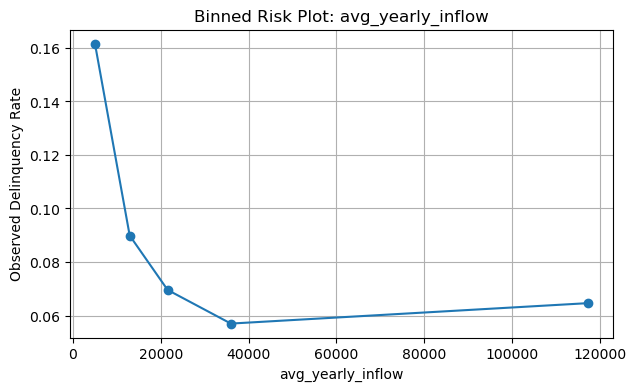

/tmp/ipykernel_38699/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


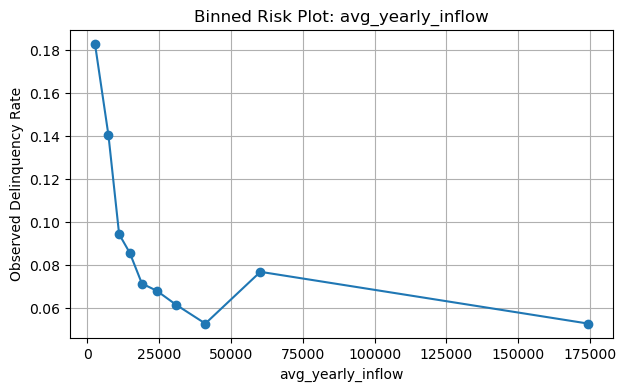

,bin,risk_rate,count,feature_mean
0,"(0.019, 5364.01]",0.182913,913,2677.868598
1,"(5364.01, 9310.322]",0.140197,913,7385.482892
2,"(9310.322, 12828.12]",0.094195,913,11094.390493
3,"(12828.12, 16834.254]",0.085526,912,14791.567588
4,"(16834.254, 21399.78]",0.071194,913,19026.129069
5,"(21399.78, 27151.348]",0.067908,913,24126.009869
6,"(27151.348, 34973.774]",0.061404,912,30841.038925
7,"(34973.774, 49173.874]",0.052574,913,41099.668576
8,"(49173.874, 77535.141]",0.076670,913,60247.724414
9,"(77535.141, 2307905.6]",0.052574,913,174306.313384


In [113]:
plot_binned_risk_5(df_eval, "avg_yearly_inflow")
plot_binned_risk_10(df_eval, "avg_yearly_inflow")

makes the most sense,  as average inflow increases, the deliquency rate decreases

/tmp/ipykernel_38699/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


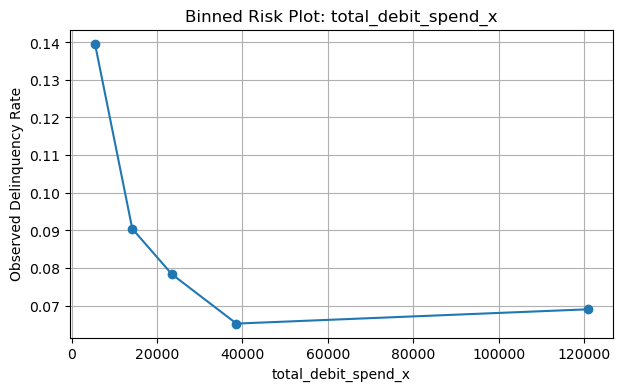

/tmp/ipykernel_38699/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


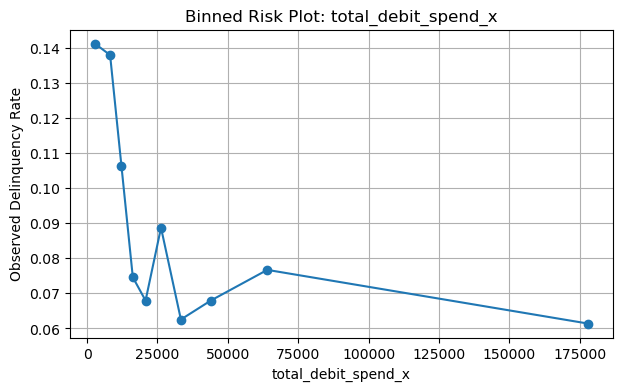

,bin,risk_rate,count,feature_mean
0,"(-0.001, 5735.322]",0.141292,913,2788.864195
1,"(5735.322, 10377.326]",0.138007,913,8174.458664
2,"(10377.326, 14151.071]",0.106243,913,12215.730241
3,"(14151.071, 18338.47]",0.074561,912,16242.589112
4,"(18338.47, 23175.015]",0.067908,913,20767.750942
5,"(23175.015, 29535.216]",0.088719,913,26251.165871
6,"(29535.216, 37537.379]",0.062500,912,33312.542785
7,"(37537.379, 51615.798]",0.067908,913,43921.400920
8,"(51615.798, 81061.442]",0.076670,913,63993.079847
9,"(81061.442, 2356517.89]",0.061336,913,177923.714294


In [114]:
plot_binned_risk_5(df_eval, "total_debit_spend_x")
plot_binned_risk_10(df_eval, "total_debit_spend_x")

the plot shows that people who spend very little tend to have higher delinquency risk, while people who spend more overall tend to have lower risk. this is likely because higher spending reflects greater income and financial capacity, whereas very low spending may indicate financial stress or limited resources

/tmp/ipykernel_38699/4156484538.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


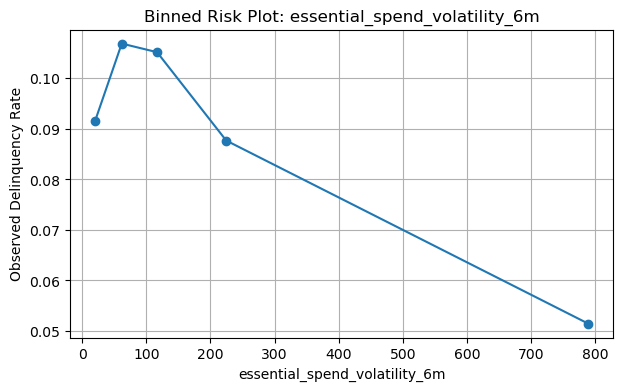

/tmp/ipykernel_38699/4156484538.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


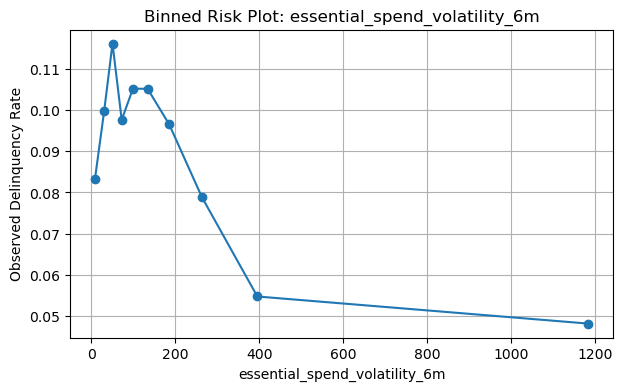

,bin,risk_rate,count,feature_mean
0,"(-0.001, 21.382]",0.083242,913,8.941355
1,"(21.382, 40.8]",0.099671,913,30.806951
2,"(40.8, 60.95]",0.116101,913,50.748465
3,"(60.95, 85.095]",0.097588,912,72.650654
4,"(85.095, 114.772]",0.105148,913,99.300101
5,"(114.772, 156.833]",0.105148,913,134.256957
6,"(156.833, 218.955]",0.096491,912,185.773718
7,"(218.955, 316.374]",0.078861,913,263.510161
8,"(316.374, 505.33]",0.054765,913,395.453437
9,"(505.33, 25802.404]",0.048193,913,1182.752109


In [115]:
plot_binned_risk_5(df_eval, "essential_spend_volatility_6m")
plot_binned_risk_10(df_eval, "essential_spend_volatility_6m")

this plot shows that delinquency risk does not increase with higher volatility in essential spending. instead, risk is highest for consumers with low to moderate volatility and decreases sharply for those with very high volatility. while this may seem counterintuitive, high volatility likely reflects financial flexibility and higher income, whereas low volatility may indicate constrained budgets with limited ability to absorb shocks

In [116]:
plot_binned_risk(df_eval, "monthly_net_min")

NameError: name 'plot_binned_risk' is not defined

- `monthly_net_min` is the one's worst month financially (money in - money out)
- at first glance, this plot seems backwards because wouldn't the people that have less money than they made in a month be more unlikely to pay back a loan
- after looking at this plot, we can think people with negative months probably have a higher overall income, can move money around, can have high losses bc they know they can recover; those with net zero live very close to their limit, have little or no financial buffer, are more vulnerable to falling behind

In [ ]:
tmp = monthly_features[['prism_consumer_id', 'monthly_net_min', 'DQ_TARGET']].copy()

tmp['bin'] = pd.qcut(
    tmp['monthly_net_min'],
    q=10,
    duplicates='drop'
)
first_bin = tmp['bin'].cat.categories[0]
first_bin

In [ ]:
first_bin_consumers = tmp[tmp['bin'] == first_bin]
first_bin_consumers


In [ ]:
cols_to_inspect = [
    "prism_consumer_id",
    "monthly_net_min",
    "monthly_net_avg",
    "monthly_net_max",
    "monthly_net_total",
    "avg_yearly_inflow",
    "std_inflow",
    "num_transactions",
    "DQ_TARGET"
]

available_cols = [c for c in cols_to_inspect if c in df_eval.columns]

inspect_df = (
    first_bin_consumers[["prism_consumer_id"]]   # keep just the ids from the bin
    .merge(df_eval[available_cols], on="prism_consumer_id", how="left")
)

inspect_df.head()



In [ ]:
inspect_df.sort_values("monthly_net_min").head(10)


In [ ]:
trxndf[
    (trxndf['prism_consumer_id'] == '2267') &
    (trxndf['credit_or_debit'] == 'DEBIT')
].sort_values(['amount'], ascending = False)

???!?!??

In [ ]:
plot_binned_risk(df_eval, "has_overdraft_6m")


this feature is binary so this plot actually doesn't make sense 

In [ ]:
df_eval.groupby("has_overdraft_6m")["DQ_TARGET"].agg(
    risk_rate="mean",
    count="size"
)


consumers who had overdraft in the last 6 months are more than twice as likely to become delinquent compared to those who did not overdraft

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,          # more trees
    max_depth=6,               # slightly deeper interactions
    learning_rate=0.03,        # slower learning → better generalization
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,        # reduce noisy splits
    gamma=0.1,                 # require meaningful gain
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)


xgb.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

In [ ]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance

### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=1   # speed up elimination
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
xgb_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = xgb_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Random Forest Model ---
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,        # use all cores
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=rf_model,
    n_features_to_select=50,
    step=5   # step=1 = slow but precise, step=5 faster
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
rf_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = rf_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


In [ ]:
rf_full = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

rf_full.fit(X_train, y_train)
full_probs = rf_full.predict_proba(X_test)[:, 1]
full_auc = roc_auc_score(y_test, full_probs)

print("Full Feature AUC:", full_auc)
print("RFE Feature AUC:", auc_score)


In [ ]:
X = X.drop(columns='credit_score')

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Forward Selection ---
selected_features = []
remaining_features = list(X.columns)
target_feature_count = 50

for i in range(target_feature_count):
    best_auc = 0
    best_feat = None
    
    for feat in remaining_features:
        current_feats = selected_features + [feat]
        model = RandomForestClassifier(
            n_estimators=200,
            n_jobs=-1,
            random_state=42
        )
        model.fit(X_train[current_feats], y_train)
        y_probs = model.predict_proba(X_test[current_feats])[:, 1]
        auc = roc_auc_score(y_test, y_probs)
        
        if auc > best_auc:
            best_auc = auc
            best_feat = feat
    
    if best_feat is None:
        print("No improvement; stopping early.")
        break
    
    selected_features.append(best_feat)
    remaining_features.remove(best_feat)
    print(f"Step {i+1}: Added feature '{best_feat}' with AUC={best_auc:.4f}")

# --- Final Selected Features ---
print("Top 50 Selected Features:", selected_features)

# --- Train Final Model ---
final_model = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)
final_model.fit(X_train[selected_features], y_train)

y_probs = final_model.predict_proba(X_test[selected_features])[:, 1]
final_auc = roc_auc_score(y_test, y_probs)
print("Final Test ROC-AUC:", final_auc)

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# X = dataframe of features
# y = target column (0/1)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Forward Selection ---
selected_features = []
remaining_features = list(X.columns)
target_feature_count = 50

for i in range(target_feature_count):
    best_auc = 0
    best_feat = None
    
    for feat in remaining_features:
        current_feats = selected_features + [feat]
        
        model = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="auc",
            random_state=42
        )
        model.fit(X_train[current_feats], y_train)
        
        y_probs = model.predict_proba(X_test[current_feats])[:, 1]
        auc = roc_auc_score(y_test, y_probs)
        
        if auc > best_auc:
            best_auc = auc
            best_feat = feat
    
    if best_feat is None:
        print("No improvement; stopping early.")
        break
    
    selected_features.append(best_feat)
    remaining_features.remove(best_feat)
    print(f"Step {i+1}: Added feature '{best_feat}' with AUC={best_auc:.4f}")

# --- Final Selected Features ---
print("Top 50 Selected Features:", selected_features)

# --- Train Final XGBoost Model ---
final_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)
final_model.fit(X_train[selected_features], y_train)

y_probs = final_model.predict_proba(X_test[selected_features])[:, 1]
final_auc = roc_auc_score(y_test, y_probs)
print("Final Test ROC-AUC:", final_auc)
